## Import all the Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from functools import reduce

import squarify as sq

import folium
from folium.plugins import HeatMap

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import urllib
from io import BytesIO 
import requests

import warnings
warnings.filterwarnings('ignore')

### Reading the Datasets

In [2]:
customers = pd.read_csv('data/olist_customers_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
reviews= pd.read_csv('data/olist_order_reviews_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
payments= pd.read_csv('data/olist_order_payments_dataset.csv')

Removing all duplicate records from geolocation

In [3]:
geolocation_zip_code_prefix = geolocation.groupby('geolocation_zip_code_prefix')['geolocation_zip_code_prefix'].size()
geolocation_zip_code_prefix[geolocation_zip_code_prefix > 1]

geolocation_zip_code_prefix
1001     26
1002     13
1003     17
1004     22
1005     25
         ..
99960     5
99965     6
99970    21
99980    26
99990     2
Name: geolocation_zip_code_prefix, Length: 17972, dtype: int64

In [4]:
geolocation = geolocation.drop_duplicates(subset='geolocation_zip_code_prefix', keep='first')

### Data Analysis - understanding the context

In [5]:
#checking number of columns , column_names and no_of_rows

datasets = [customers,geolocation,order_items, payments, orders, products,reviews,sellers]
titles = ["customers","geolocations","order_items", "payments", "orders", "products","reviews","sellers"]



info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Greys')

In [6]:
datasets = [customers,geolocation,order_items, payments, orders, products,reviews,sellers]
titles = ["customers","geolocations","order_items", "payments", "orders", "products","reviews","sellers"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Greys')

Observation(s):

- The maximum number of null-values are present in reviews dataset and the name of the columns with the null-values are review_comment_title and review_comment_message.
- products dataset contains least number of null- values but most of its columns has null-values.
- we have to deal with these null-values in future.

In [7]:
reviews = reviews.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp','review_comment_message'],axis=1)

#### Merging all the datasets

In [8]:
#list with datasets with PK and FK 'order_id'
ordersList = [orders, order_items]

#merge, join multiple datasets with the same FK:
data = reduce(lambda data1, data2: pd.merge(data1, data2, on='order_id', how='left'), ordersList)

data = pd.merge(data, products, on='product_id', how='outer')

data = pd.merge(data, sellers, on='seller_id', how='outer')

#merge final data with the same FK (customer_id):
data = pd.merge(data, customers, on='customer_id', how='outer')

data = pd.merge(data, geolocation, left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix')

data = pd.merge(data,reviews,on='order_id', how='left')

data = pd.merge(data,payments, on='order_id', how='left')

#### Checking Null Values

In [9]:
data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     2074
order_delivered_customer_date    3402
order_estimated_delivery_date       0
order_item_id                     828
product_id                        828
seller_id                         828
shipping_limit_date               828
price                             828
freight_value                     828
product_category_name            2531
product_name_lenght              2531
product_description_lenght       2531
product_photos_qty               2531
product_weight_g                  848
product_length_cm                 848
product_height_cm                 848
product_width_cm                  848
seller_zip_code_prefix            828
seller_city                       828
seller_state                      828
customer_unique_id                  0
customer_zip

##### Handling Missing Value

In [10]:
df=data.copy()

In [11]:
type_and_missing = pd.concat([df.isna().sum().sort_values(ascending = False), 
                              ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False), 
                              df.dtypes], axis=1, keys=['Total', 'Missing_%','Type'])
type_and_missing[type_and_missing['Total'] > 0]

Total  Missing_%     Type
order_delivered_customer_date   3402   2.862937   object
product_photos_qty              2531   2.129951  float64
product_description_lenght      2531   2.129951  float64
product_name_lenght             2531   2.129951  float64
product_category_name           2531   2.129951   object
order_delivered_carrier_date    2074   1.745365   object
product_length_cm                848   0.713631  float64
product_width_cm                 848   0.713631  float64
product_height_cm                848   0.713631  float64
product_weight_g                 848   0.713631  float64
freight_value                    828   0.696800  float64
seller_state                     828   0.696800   object
shipping_limit_date              828   0.696800   object
price                            828   0.696800  float64
seller_city                      828   0.696800   object
seller_id                        828   0.696800   object
product_id                       828   0.696800   object
order_item_id                    828   0.696800  float64
seller_zip_code_prefix           828   0.696800  float64
order_approved_at                176   0.148112   object
payment_sequential                 3   0.002525  float64
payment_type                       3   0.002525   object
payment_installments               3   0.002525  float64
payment_value                      3   0.002525  float64

In [12]:
#Handling missing values
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)
df.drop(labels='product_description_lenght',axis=1,inplace=True)
df.drop(labels='product_name_lenght',axis=1,inplace=True)

In [13]:
# Handling missing values of numerical features
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)
df['freight_value'].fillna(df['freight_value'].mean(),inplace=True)
df['order_item_id'].fillna(df['order_item_id'].median(),inplace=True)
df['product_photos_qty'].fillna(df['product_photos_qty'].median(),inplace=True)
df['price'].fillna(df['price'].mean(),inplace=True)
df['shipping_limit_date'].fillna((df['shipping_limit_date'].astype('datetime64[ns]') - df['order_purchase_timestamp'].astype('datetime64[ns]')).mean(),inplace=True)

In [14]:
df=df.dropna()

In [15]:
type_and_missing = pd.concat([df.isna().sum().sort_values(ascending = False), 
                              ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False), 
                              df.dtypes], axis=1, keys=['Total', 'Missing_%','Type'])
type_and_missing[type_and_missing['Total'] > 0]

Empty DataFrame
Columns: [Total, Missing_%, Type]
Index: []

### De-duplicating the data

In [16]:
dup_rows = df[df.duplicated(['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','product_id'])]
dup_rows.value_counts()

order_id                       customer_id  \
1   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
4   70b35acffdf851e782ebf6fbc35eb620  8e8ee9b08afb49b080d193f98b0505af   
23  d4e770b405f1a265106474eaf37ded74  7c7b0230efd9524afdba267f0d4c70b7   
73  24bf227d444a1df7957f78e6f03bc5b6  25c12681274a662fb98ea0eeef8405c2   

   order_status order_purchase_timestamp    order_approved_at  \
1     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
4     delivered      2018-03-22 17:23:21  2018-03-22 18:05:36   
23    delivered      2017-10-04 18:18:28  2017-10-04 18:35:08   
73    delivered      2018-07-23 12:27:09  2018-07-23 15:32:00   

   order_delivered_customer_date order_estimated_delivery_date  order_item_id  \
1            2017-10-10 21:25:13           2017-10-18 00:00:00            1.0   
2            2017-10-10 21:25:13           2017-10-18 00:00:00            1.0   
4            2018-03-25 17:22:41           2018-04-04 00:00:00            2.0   
23           2017-10-13 14:44:59           2017-11-01 00:00:00            2.0   
73           2018-08-09 00:22:36           2018-08-22 00:00:00            1.0   

                          product_id                         seller_id  ...  \
1   87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9  ...   
2   87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9  ...   
4   6cc44821f36f3156c782da72dd634e47  da8622b14eb17ae2831f4ac5b9dab84a  ...   
23  f7f59e6186e10983a061ac7bdb3494d6  729f06993dac8e860d4f02d7088ca48a  ...   
73  b7f7b781db33f7f78996fea3804d6766  612170e34b97004b3ba37eae81836b4c  ...   

   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
1                         3149       -23.574809       -46.587471   
2                         3149       -23.574809       -46.587471   
4                         3149       -23.574809       -46.587471   
23                       88032       -27.536913       -48.509018   
73                       13060       -22.943831       -47.112332   

   geolocation_city  geolocation_state  review_score  payment_sequential  \
1         sao paulo                 SP             4                 3.0   
2         sao paulo                 SP             4                 2.0   
4         sao paulo                 SP             5                 1.0   
23    florianopolis                 SC             5                 1.0   
73         campinas                 SP             3                 1.0   

    payment_type  payment_installments  payment_value  
1        voucher                   1.0           2.00  
2        voucher                   1.0          18.59  
4    credit_card                   2.0         223.38  
23   credit_card                   3.0         111.48  
73   credit_card                   1.0          14.77  

[5 rows x 36 columns]

In [155]:
dup_rows.shape

(15608, 36)

In [17]:
#Deduplication of entries
df= df.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'}, keep='first', inplace=False)
df=df.reindex()
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  70b35acffdf851e782ebf6fbc35eb620  8e8ee9b08afb49b080d193f98b0505af   
5  69923a4e07ce446644394df37a710286  31f31efcb333fcbad2b1371c8cf0fa84   
6  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
7  ded23d37cdcc25b37b4473b7be770cb2  f96144f946e8e590fabf60a3a1e3342e   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-03-22 17:23:21  2018-03-22 18:05:36   
5    delivered      2017-09-04 11:26:38  2017-09-04 11:43:25   
6    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
7    delivered      2018-07-26 18:25:40  2018-07-27 02:10:26   

  order_delivered_customer_date order_estimated_delivery_date  order_item_id  \
0           2017-10-10 21:25:13           2017-10-18 00:00:00            1.0   
3           2018-03-25 17:22:41           2018-04-04 00:00:00            1.0   
5           2017-09-05 19:20:20           2017-09-15 00:00:00            1.0   
6           2017-08-18 14:44:43           2017-08-28 00:00:00            1.0   
7           2018-08-07 12:12:23           2018-08-20 00:00:00            1.0   

                         product_id                         seller_id  ...  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9  ...   
3  6cc44821f36f3156c782da72dd634e47  da8622b14eb17ae2831f4ac5b9dab84a  ...   
5  9abb00920aae319ef9eba674b7d2e6ff  1771297ac436903d1dd6b0e9279aa505  ...   
6  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9  ...   
7  a0b7d5a992ccda646f2d34e418fff5a0  95f83f51203c626648c875dd41874c7f  ...   

  geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                        3149       -23.574809       -46.587471   
3                        3149       -23.574809       -46.587471   
5                        3149       -23.574809       -46.587471   
6                        3366       -23.565578       -46.534603   
7                        3366       -23.565578       -46.534603   

  geolocation_city  geolocation_state  review_score  payment_sequential  \
0        sao paulo                 SP             4                 1.0   
3        sao paulo                 SP             5                 1.0   
5        sao paulo                 SP             5                 1.0   
6        sao paulo                 SP             4                 1.0   
7        sao paulo                 SP             5                 1.0   

   payment_type  payment_installments  payment_value  
0   credit_card                   1.0          18.12  
3   credit_card                   2.0         223.38  
5   credit_card                   1.0          44.11  
6   credit_card                   3.0          37.77  
7        boleto                   1.0         102.08  

[5 rows x 36 columns]

In [18]:
print("Number of rows before deduplication:",len(data))
print("Number of columns before deduplication:",len(data.columns))
print("Number of rows after deduplication:",len(df))
print("Number of columns after deduplication:",len(df.columns))

Number of rows before deduplication: 118829
Number of columns before deduplication: 39
Number of rows after deduplication: 97008
Number of columns after deduplication: 36


## Exploratory Data Analysis

In [19]:
totalOrders = orders.order_id.nunique()

print('Unique customer cities:',df.customer_city.nunique())
print('Unique customer states:',df.customer_state.nunique())
print('Unique seller states:',df.seller_state.nunique())
print('Average price:',df.price.sum() / totalOrders)
print('Average qnt of products by order:',df.order_item_id.sum() / totalOrders)
print('Average freight price:',df.freight_value.sum() / totalOrders)
print('Total revenue for the period was:',df.price.sum())
print('Number of unique customers:',df.customer_unique_id.nunique())
print('Total order quantity:', totalOrders)
print('Average number of product by order:',df.freight_value.sum() / totalOrders)

Unique customer cities: 4051
Unique customer states: 27
Unique seller states: 23
Average price: 122.95021037600185
Average qnt of products by order: 0.991894691324504
Average freight price: 19.716638609828948
Total revenue for the period was: 12226291.87
Number of unique customers: 93849
Total order quantity: 99441
Average number of product by order: 19.716638609828948


In [20]:
priceGrouped = df.groupby('order_id')['price'].sum()
priceGrouped.describe()

count    97008.000000
mean       126.033852
std        191.098474
min          0.850000
25%         41.900000
50%         79.000000
75%        139.900000
max       6735.000000
Name: price, dtype: float64

<AxesSubplot:title={'center':'Total Price (Order Value in R$) by State of the Customer'}, xlabel='customer_state', ylabel='price'>

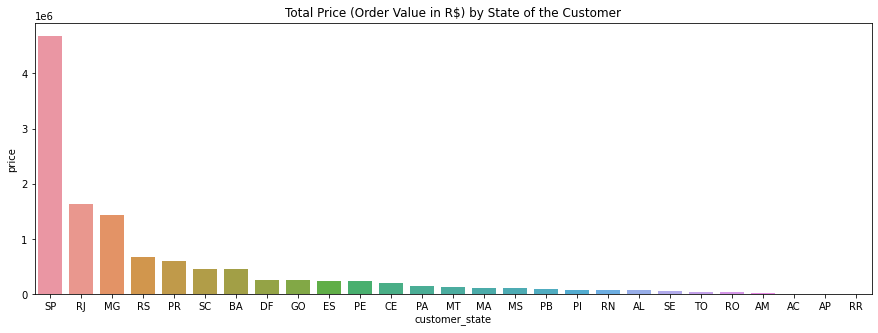

In [21]:
totalByState = df.groupby('customer_state')['price'].sum().sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.title('Total Price (Order Value in R$) by State of the Customer')
sns.barplot(x=totalByState.index, y=totalByState)

<AxesSubplot:title={'center':'Total Orders (Count) by State of the Customer'}, xlabel='customer_state', ylabel='order_id'>

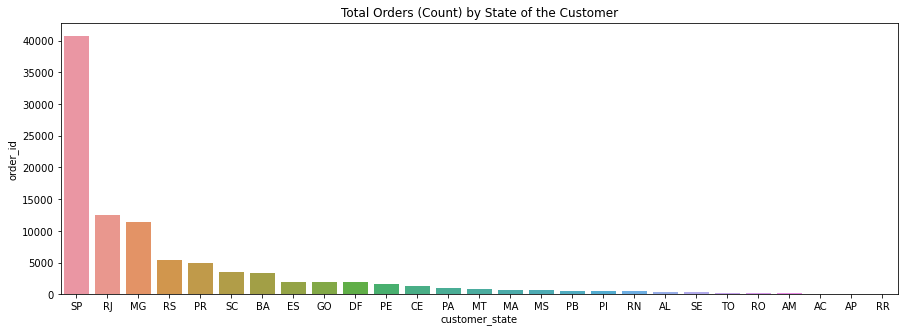

In [22]:
totalOrdersByState = df.groupby('customer_state')['order_id'].nunique().sort_values(ascending=False)
totalOrdersByState

plt.figure(figsize=(15,5))
plt.title('Total Orders (Count) by State of the Customer')
sns.barplot(x=totalOrdersByState.index, y=totalOrdersByState)

Here, we see that for customer state SP, we have maximum revenue being generated and also maximum number of orders

<AxesSubplot:title={'center':'States with more sells'}>

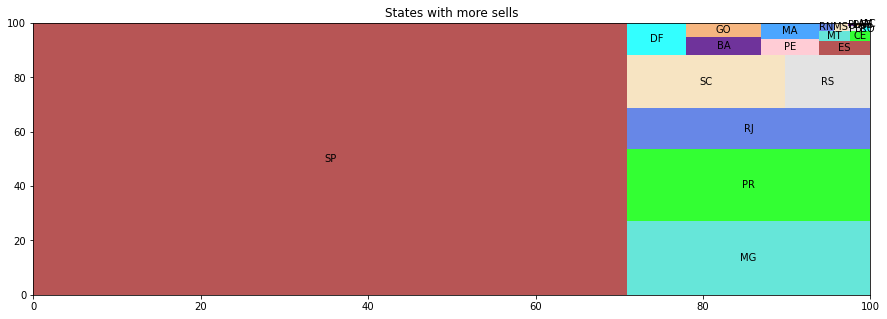

In [23]:
totalSellerByState = df.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False)
totalSellerByState

# Define the plot sizes
fig, ax = plt.subplots(1, figsize = (15,5))
plt.title('States with more sells')

sq.plot(sizes= totalSellerByState,
        color = ['brown','turquoise','lime','royalblue','wheat','gainsboro','aqua','indigo','sandybrown','pink','dodgerblue'],
        label= totalSellerByState.index,
        alpha = .8)

Even the sellers have maximum for the state SP

<AxesSubplot:title={'center':'Average freight value in R$ by State of the Customer'}, xlabel='customer_state'>

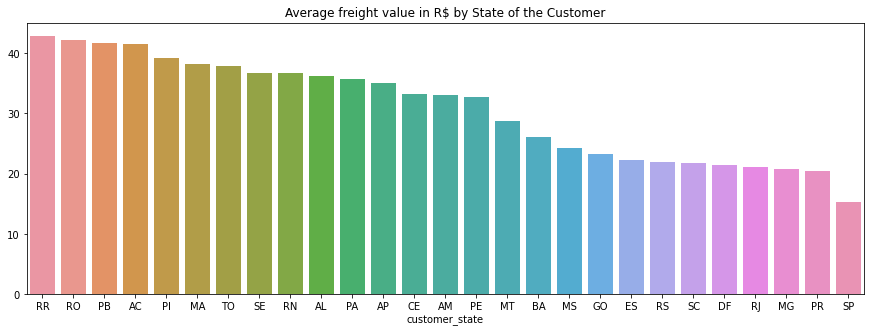

In [24]:
freightAvgState = (df.groupby('customer_state')['freight_value'].sum() /df.groupby('customer_state')['order_id'].nunique()).sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.title('Average freight value in R$ by State of the Customer')
sns.barplot(x=freightAvgState.index, y=freightAvgState)

In [25]:
mapCustomers = folium.Map(location=[-15.7941, -47.8825], 
                          tiles='cartodbpositron', 
#                           width=700, height=400,
                          zoom_start=5)

HeatMap(data=df[['geolocation_lat', 'geolocation_lng']], 
                     radius=13).add_to(mapCustomers)

print('Where are the active clients from: ')
mapCustomers

Where are the active clients from: 


<AxesSubplot:title={'center':'Top 10 categories of products with more orders'}, xlabel='product_category_name'>

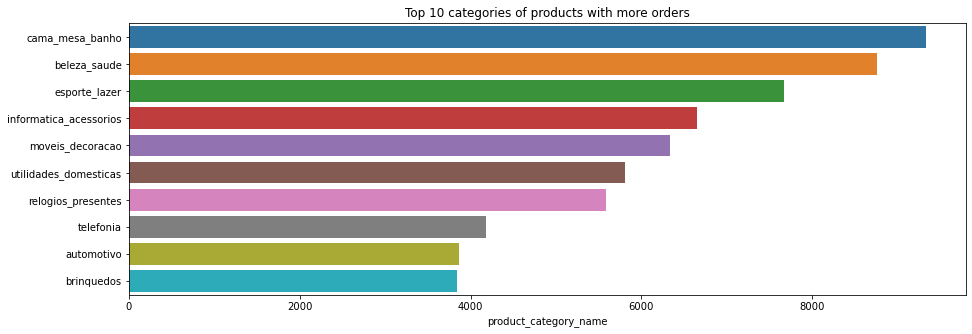

In [26]:
productCategoryOrders = df['product_category_name'].value_counts().head(10)

plt.figure(figsize=(15,5))
plt.title('Top 10 categories of products with more orders')
sns.barplot(y=productCategoryOrders.index, x=productCategoryOrders, orient='h')

<AxesSubplot:title={'center':'Reviews'}, xlabel='review_score'>

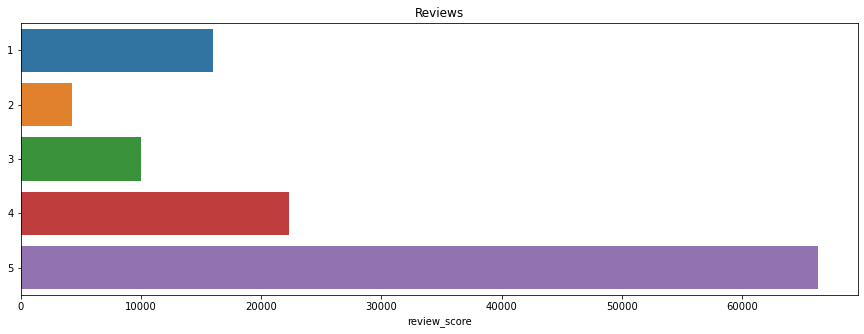

In [27]:
reviewsScore = data.review_score.value_counts()

plt.figure(figsize=(15,5))
plt.title('Reviews')
sns.barplot(y=reviewsScore.index, x=reviewsScore, orient='h')

In [28]:
sellerStateReviews = df.groupby('seller_state')['review_score'].mean()
customerStateReviews = df.groupby('customer_state')['review_score'].mean()

concatReviews = pd.concat([sellerStateReviews.rename('seller'), customerStateReviews.rename('customer')], axis=1)

<AxesSubplot:ylabel='customer'>

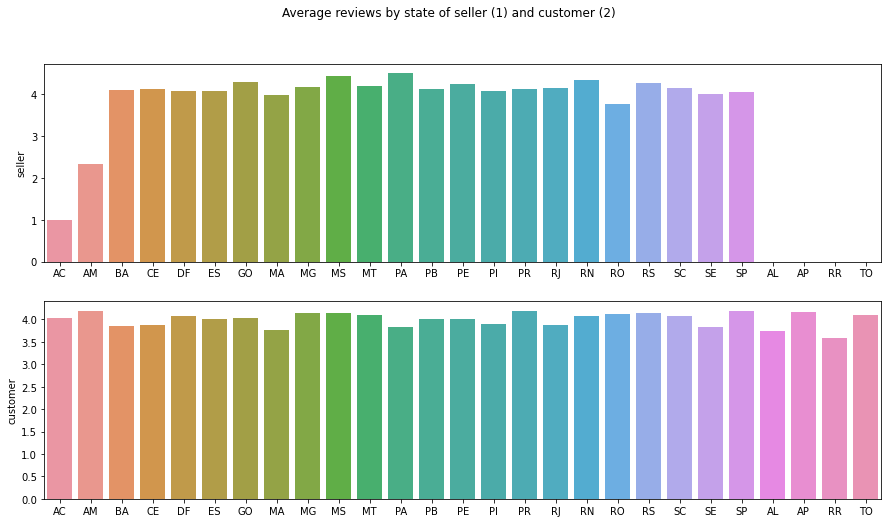

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
fig.suptitle('Average reviews by state of seller (1) and customer (2)')

sns.barplot(x=concatReviews.index, y=concatReviews.seller, ax=axes[0])

sns.barplot(x=concatReviews.index, y=concatReviews.customer, ax=axes[1])

<AxesSubplot:title={'center':'Correlation between price and reviews'}, xlabel='review_score', ylabel='price'>

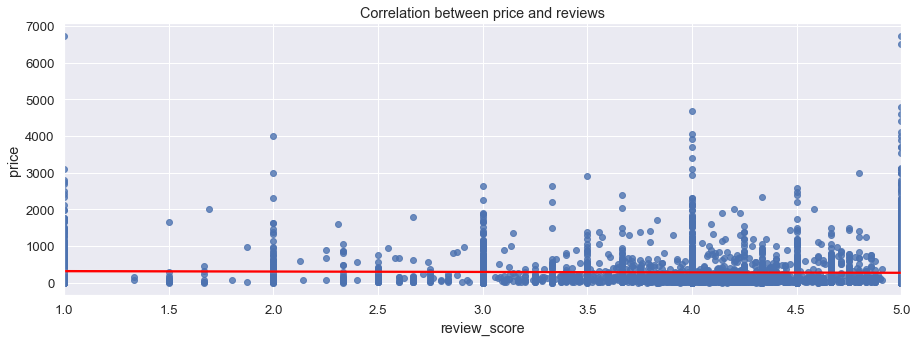

In [157]:
prodCatReviewsByPrice = pd.DataFrame(df.groupby('price')['review_score'].mean()).reset_index()

plt.figure(figsize=(15,5))
plt.title('Correlation between price and reviews')
sns.regplot(y='price', x='review_score', data=prodCatReviewsByPrice, line_kws={"color": "red"})

In [158]:
c1 = prodCatReviewsByPrice[prodCatReviewsByPrice['price']<30]['review_score'].mean()
c2 = prodCatReviewsByPrice[(prodCatReviewsByPrice['price']>=30) & (prodCatReviewsByPrice['price']<100)]['review_score'].mean()
c3 = prodCatReviewsByPrice[(prodCatReviewsByPrice['price']>=100) & (prodCatReviewsByPrice['price']<1000)]['review_score'].mean()
c4 = prodCatReviewsByPrice[(prodCatReviewsByPrice['price']>=1000)]['review_score'].mean()

levels = ['up to R$30', 'R$30 - R$100', 'R$100 - R$1000', 'above R$1000']

for i in range(len(levels)):
    value = 'c{}'.format(i+1)
    print('Avg Review Score for price {}: {}'.format(levels[i], globals()[value]))

Avg Review Score for price up to R$30: 4.120748548726716
Avg Review Score for price R$30 - R$100: 4.102169945376423
Avg Review Score for price R$100 - R$1000: 4.044065638417394
Avg Review Score for price above R$1000: 3.993602769389424


<AxesSubplot:xlabel='review_score', ylabel='product_category_name'>

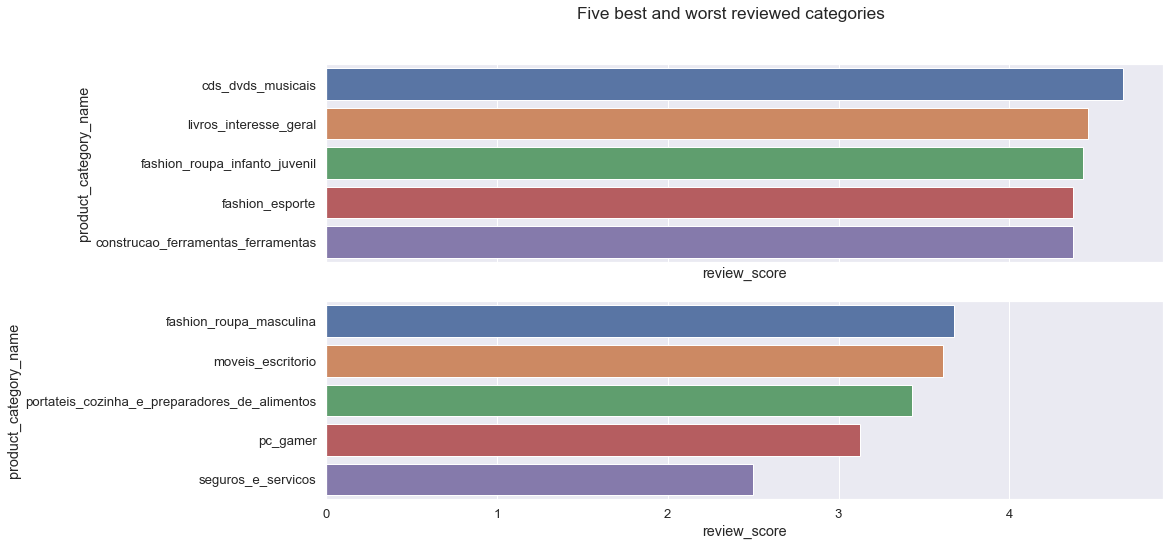

In [159]:
plotCats = pd.DataFrame(df.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15,8), sharex=True)
fig.suptitle('Five best and worst reviewed categories')

sns.barplot(y='product_category_name', x='review_score', ax=axes[0], data=plotCats.head(5))
sns.barplot(y='product_category_name', x='review_score', ax=axes[1], data=plotCats.tail(5))

In [30]:
# Convert objects date columns to dates desconsidering the errors
dateColumns = ['order_purchase_timestamp', 'order_approved_at',  'order_delivered_customer_date', 'order_estimated_delivery_date']

for column in dateColumns:
    df[column] = pd.to_datetime(df[column], errors='coerce')

#Calculate the difference between the estimated date and the delivery (negative values means delay)
df['DiffDeliveryDays'] = ((df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days) + 1

#Calculate the time between end of purchase and delivery
df['DeliveryCountDays'] = ((df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days)

<AxesSubplot:xlabel='DiffDeliveryDays', ylabel='review_score'>

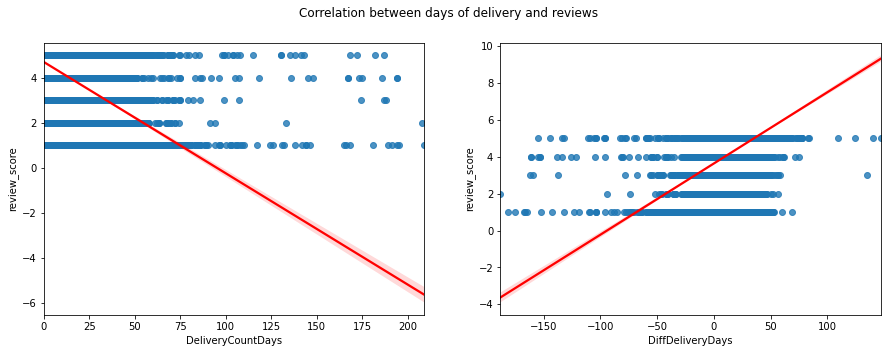

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Correlation between days of delivery and reviews')

sns.regplot(x='DeliveryCountDays', y='review_score', data=df, ax=axes[0], line_kws={"color": "red"})

sns.regplot(x='DiffDeliveryDays', y='review_score', data=df, ax=axes[1], line_kws={"color": "red"})

In [160]:
print('Average review score for delayed items:',(df[df.DiffDeliveryDays<0]['review_score'].mean()))
print('Average review score for anticipated items:',(df[df.DiffDeliveryDays>0]['review_score'].mean()))

Average review score for delayed items: 2.256897895557288
Average review score for anticipated items: 4.224571812381059


### Creating Churn Flag

**So churn is defined as, customer has churned if his last purchase with his previous purchase is more than 180 days**

In [33]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['diff'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','diff']], on='customer_unique_id')

df_user[df_user['diff']>180]

customer_unique_id  diff
0      7c396fd4830fd04220f754e42b4e5bff   335
1      7c396fd4830fd04220f754e42b4e5bff   335
3      3a51803cc0d012c3b5dc8b7528cb05f7   383
5      55fd57195ae0bd2ecf368bbc4be6ad96   427
7      ef0996a1a279c26e7ecbd737be23d235   396
...                                 ...   ...
97003  5ede9beb1608cb450626b3c83db9f8ec   333
97004  a1644581211b1c1d4933064a411ad7de   427
97005  9d4e2b9608fc029188a1ad31174aeef3   563
97006  34f2ec40e13a7f433b8ef0aa77426e77   189
97007  78a159045124eb7601951b917a42034f   540

[58072 rows x 2 columns]

In [34]:
df_user = df_user.sort_values('diff').drop_duplicates(keep='first')

In [35]:
df_dev = pd.merge(df,df_user,how='inner',on='customer_unique_id')

In [36]:
df_dev.sample(10)

order_id                       customer_id  \
78276  e5b84cb2e43872d1757d71fb8eec54f4  b7e4844cb302e128776dd81691cb626a   
40943  20c93204065c1cc43ac91fe4358f8983  d53782279acdd8fad99e3908be8bbcf1   
58103  28cf6655a339bec298464ed6ac5b4550  3ab22580c82d3db7531aba1fc5fe49c1   
29673  747af114bbea56ac1e6841d66553b0bc  3f9f956720566758b250a7701b100564   
80432  fccfc993172f9dcf96a728c266a98dad  703e8b6dee6efc4fda4d67dd5825d28f   
8054   2fe2b3f315aee60c3f8f15af8d3e0ab6  e5dc189e17c8e7a8830dcde5a05e5a7a   
8827   768351bcdb7630b77da379eb5a54e9b3  22e7d05a63bb1bfe0b2eede7b74723c8   
90587  96a35cb03c27e713024403b81eface30  d9835e397f7812d5257f6033b9ceba0e   
9271   87aa53fa9466f416f97e7d380fbff012  97c149fcb8426cae07a0f1eeed3c089d   
63396  6c5222e0550b757a63908aa2f0cacf95  a0d7296689347a9f6c7a89b03281db68   

      order_status order_purchase_timestamp   order_approved_at  \
78276    delivered      2018-07-07 20:18:09 2018-07-07 20:30:22   
40943    delivered      2017-04-09 15:38:44 2017-04-09 15:50:12   
58103    delivered      2018-02-25 14:38:34 2018-02-25 14:50:36   
29673    delivered      2018-03-04 13:46:06 2018-03-04 13:55:33   
80432    delivered      2017-06-06 13:39:18 2017-06-06 13:50:24   
8054     delivered      2018-06-04 20:47:59 2018-06-04 21:12:34   
8827     delivered      2017-03-11 15:19:53 2017-03-11 15:19:53   
90587    delivered      2018-05-02 16:48:28 2018-05-02 17:38:08   
9271     delivered      2018-04-16 20:20:19 2018-04-17 12:12:09   
63396    delivered      2017-11-11 15:53:40 2017-11-11 16:10:40   

      order_delivered_customer_date order_estimated_delivery_date  \
78276           2018-07-12 20:02:04                    2018-07-30   
40943           2017-04-20 11:25:58                    2017-05-08   
58103           2018-03-20 21:28:51                    2018-04-02   
29673           2018-03-09 23:09:38                    2018-03-23   
80432           2017-07-03 13:22:17                    2017-07-03   
8054            2018-06-13 17:52:57                    2018-07-17   
8827            2017-04-07 14:42:17                    2017-04-11   
90587           2018-05-07 21:07:34                    2018-05-17   
9271            2018-04-24 18:46:48                    2018-05-11   
63396           2017-11-27 19:58:30                    2017-12-12   

       order_item_id                        product_id  \
78276            1.0  ab92f8667e54e4866cc3ace9e3febf97   
40943            1.0  2d4086091519b04cd687a38e33dc276c   
58103            1.0  47cd48073d67f91f09cb5ef9496c920b   
29673            1.0  1613b819ab5dae53aead2dbb4ebdb378   
80432            2.0  c211ff3068fcd2f8898192976d8b3a32   
8054             1.0  d1c427060a0f73f6b889a5c7c61f2ac4   
8827             1.0  c37e775cc9f2dd910db751444447fa3d   
90587            1.0  08c63555bbee955cad9c6a9feab9e9d4   
9271             1.0  c0dd2eb717671a095ce97504bfba29c7   
63396            1.0  310ae3c140ff94b03219ad0adc3c778f   

                              seller_id  ... geolocation_city  \
78276  929f342384a6607afe143d789ade1316  ...         camboriu   
40943  87142160b41353c4e5fca2360caf6f92  ...         sorocaba   
58103  33a6f4b1e7cdc205511e76ba1b6e0186  ...         brasilia   
29673  16090f2ca825584b5a147ab24aa30c86  ...      santa luzia   
80432  da8622b14eb17ae2831f4ac5b9dab84a  ...         brasilia   
8054   a1043bafd471dff536d0c462352beb48  ...         louveira   
8827   8fdca8e349553f99bc738833a62c8802  ...      pedra preta   
90587  117cfc326c6d50da67ca858ff5c0c852  ...        sao paulo   
9271   74bafed391319577bce6f4d2acc0589a  ...          goiania   
63396  a416b6a846a11724393025641d4edd5e  ...   estância velha   

       geolocation_state  review_score payment_sequential  payment_type  \
78276                 SC             5                1.0   credit_card   
40943                 SP             4                1.0   credit_card   
58103                 DF             1                1.0   credit_card   
29673                 MG      

In [37]:
df_dev['churn'] = [1 if diff>180 else 0 for diff in df_dev['diff']]

In [38]:
df_dev['churn'] = df_dev['churn'].astype('object')

#### EDA With Churn Flag

<AxesSubplot:title={'center':'churn'}, xlabel='churn'>

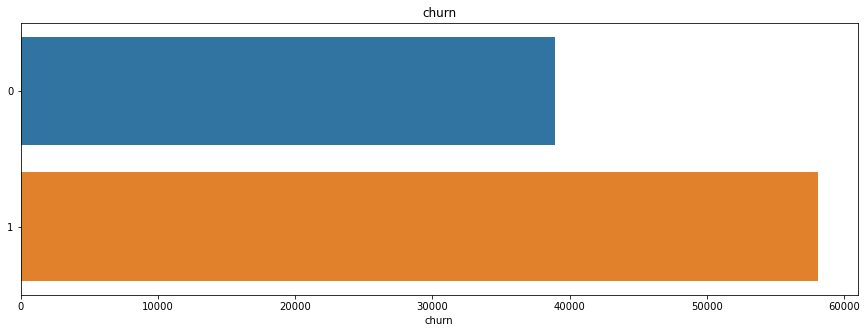

In [39]:
plt.figure(figsize=(15,5))
churn_value= df_dev.churn.value_counts()
plt.title('churn')
sns.barplot(y=churn_value.index, x=churn_value, orient='h')

In [40]:
churnbydelivery = df_dev.groupby('churn')['DiffDeliveryDays'].mean()
churnbyReview = df_dev.groupby('churn')['review_score'].mean()

concatChurnScores = pd.concat([churnbydelivery.rename('deliverydays'), churnbyReview.rename('reviewscore')], axis=1)

<AxesSubplot:xlabel='churn', ylabel='reviewscore'>

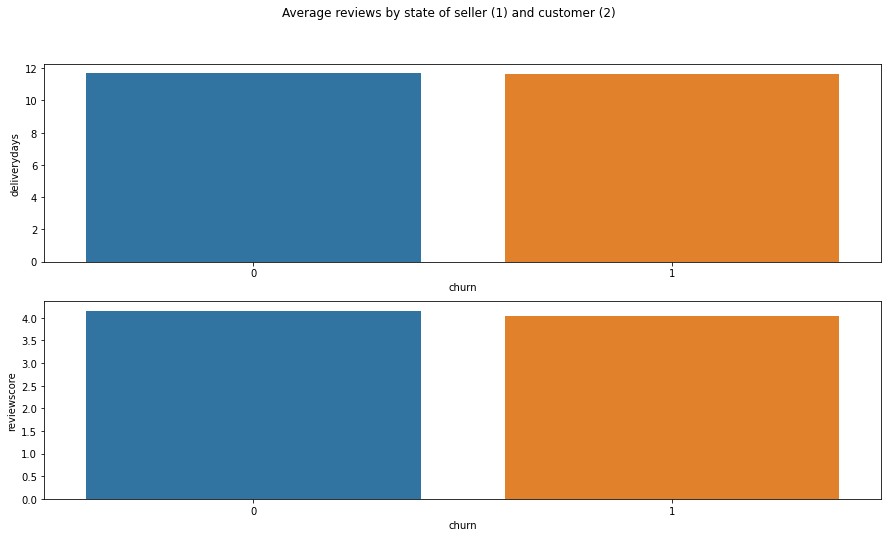

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
fig.suptitle('Average reviews by state of seller (1) and customer (2)')

sns.barplot(x=concatChurnScores.index, y=concatChurnScores.deliverydays, ax=axes[0])

sns.barplot(x=concatChurnScores.index, y=concatChurnScores.reviewscore, ax=axes[1])

Here we can that churn behaves mostly the same w.r.t time taken to deliver an order and same as with Review Score 
of the Order

<AxesSubplot:title={'center':'churn by no of orders'}, xlabel='order_id', ylabel='churn'>

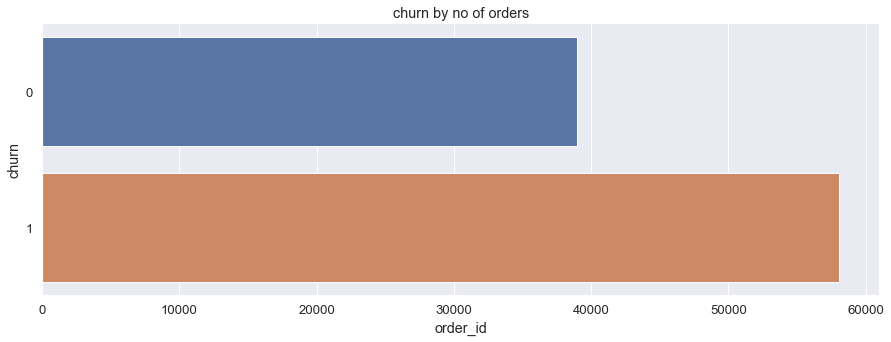

In [189]:
plt.figure(figsize=(15,5))
churnorder= df_dev.groupby('churn')['order_id'].count()
plt.title('churn by no of orders')
sns.barplot(y=churnorder.index, x=churnorder, orient='h')

<AxesSubplot:title={'center':'churn by avg price'}, xlabel='price', ylabel='churn'>

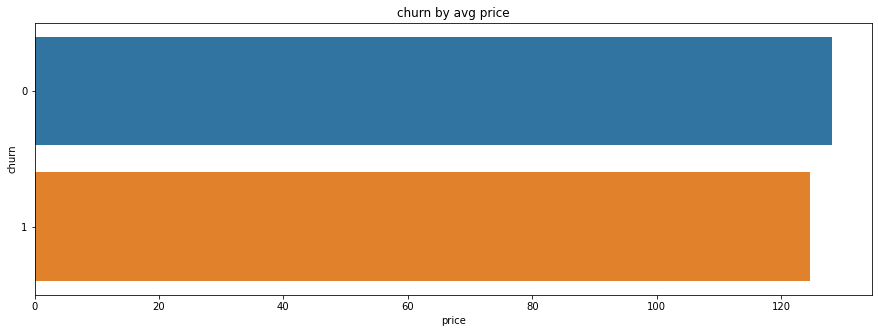

In [43]:
plt.figure(figsize=(15,5))
churnorder= df_dev.groupby('churn')['price'].mean()
plt.title('churn by avg price')
sns.barplot(y=churnorder.index, x=churnorder, orient='h')

<Figure size 432x288 with 0 Axes>

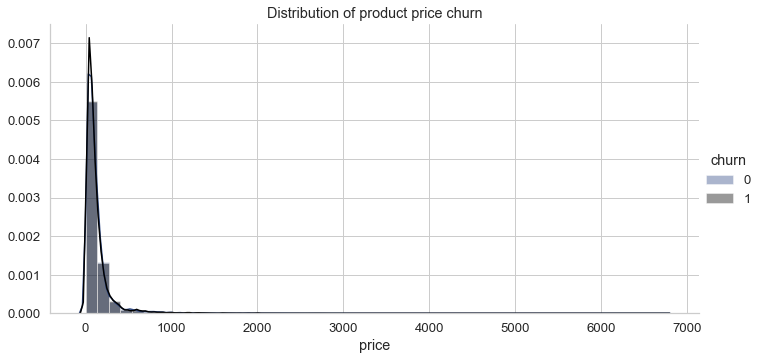

In [190]:
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df_dev, hue="churn", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "price").add_legend();
plt.title('Distribution of product price churn')
plt.show()

### Handling Outliers

<AxesSubplot:xlabel='price'>

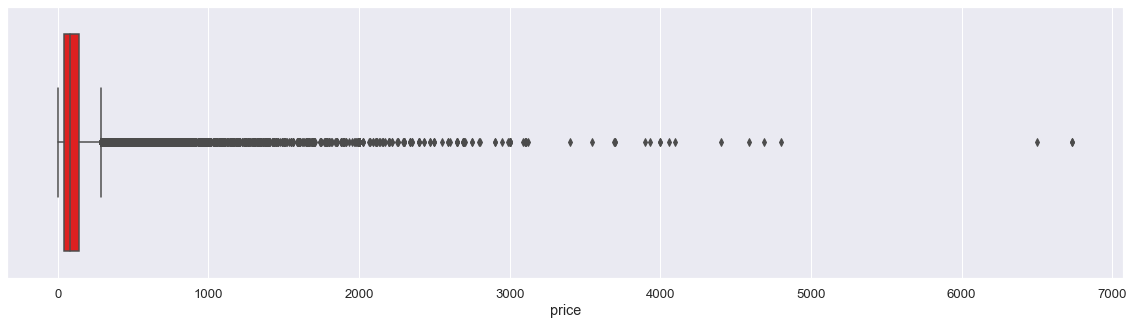

In [150]:
#Data Order Prices Analysis
plt.figure(figsize=(20,5))
sns.boxplot(x=priceGrouped, color='red')

In [45]:
order_items_silver= df_dev.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()

<AxesSubplot:xlabel='price', ylabel='freight_value'>

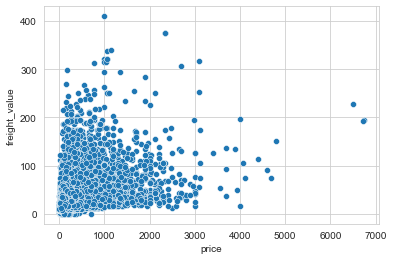

In [46]:
sns.scatterplot(x='price',y='freight_value',data=order_items_silver)

In [47]:
order_items_silver.describe()

price  freight_value
count  97008.000000   97008.000000
mean     126.033852      20.211140
std      191.098474      15.934766
min        0.850000       0.000000
25%       41.900000      13.277500
50%       79.000000      16.390000
75%      139.900000      21.260000
max     6735.000000     409.680000

As you can see, we have some outliers. how come the shipping is over 500 and which order costs over 4000?

In [48]:
percentil_freight_value = df_dev['freight_value'].quantile(0.99)
df_wo_outliers = df_dev[(df_dev['price'] <= 5000) & (df_dev['freight_value'] <= percentil_freight_value)]

In [49]:
df_wo_outliers.groupby(df_wo_outliers['DiffDeliveryDays'] < 0).size()

DiffDeliveryDays
False    89734
True      6303
dtype: int64

count    96037.000000
mean        11.652551
std         10.163090
min       -188.000000
25%          7.000000
50%         12.000000
75%         17.000000
max        147.000000
Name: DiffDeliveryDays, dtype: float64


<AxesSubplot:xlabel='DiffDeliveryDays', ylabel='Count'>

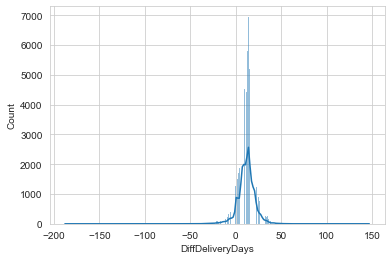

In [50]:
print(df_wo_outliers['DiffDeliveryDays'].describe())
sns.histplot(x='DiffDeliveryDays', data=df_wo_outliers, kde=True)

As we can see, the average difference between the estimated delivery and the actual delivery is 11 days, which is a bit high. Another fact is that an order was delivery 6 month later and other order was a high estimated date.

In [51]:
percentil_min_del_date = df_wo_outliers['DiffDeliveryDays'].quantile(0.01)
percentil_max_del_date = df_wo_outliers['DiffDeliveryDays'].quantile(0.91)
df1 = df_wo_outliers[(df_wo_outliers['DiffDeliveryDays'] > percentil_min_del_date)&(df_wo_outliers['DiffDeliveryDays'] < percentil_max_del_date)]

count    84685.000000
mean        10.227880
std          6.856049
min        -17.000000
25%          7.000000
50%         11.000000
75%         15.000000
max         21.000000
Name: DiffDeliveryDays, dtype: float64


<AxesSubplot:xlabel='DiffDeliveryDays', ylabel='Count'>

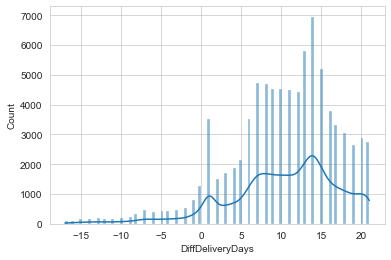

In [52]:
print(df1['DiffDeliveryDays'].describe())
sns.histplot(x='DiffDeliveryDays', data=df1, kde=True)

In [53]:
df1[df1.columns[1:]].corr()['diff'][:-1]

order_item_id                  0.000461
price                          0.012822
freight_value                 -0.033446
product_photos_qty            -0.006889
product_weight_g               0.045443
product_length_cm              0.070085
product_height_cm              0.037197
product_width_cm               0.070597
seller_zip_code_prefix         0.027804
customer_zip_code_prefix       0.051457
geolocation_zip_code_prefix    0.051457
geolocation_lat                0.009336
geolocation_lng                0.005405
review_score                  -0.022510
payment_sequential             0.022126
payment_installments           0.052214
payment_value                  0.007177
DiffDeliveryDays               0.123779
DeliveryCountDays              0.133056
Name: diff, dtype: float64

<AxesSubplot:>

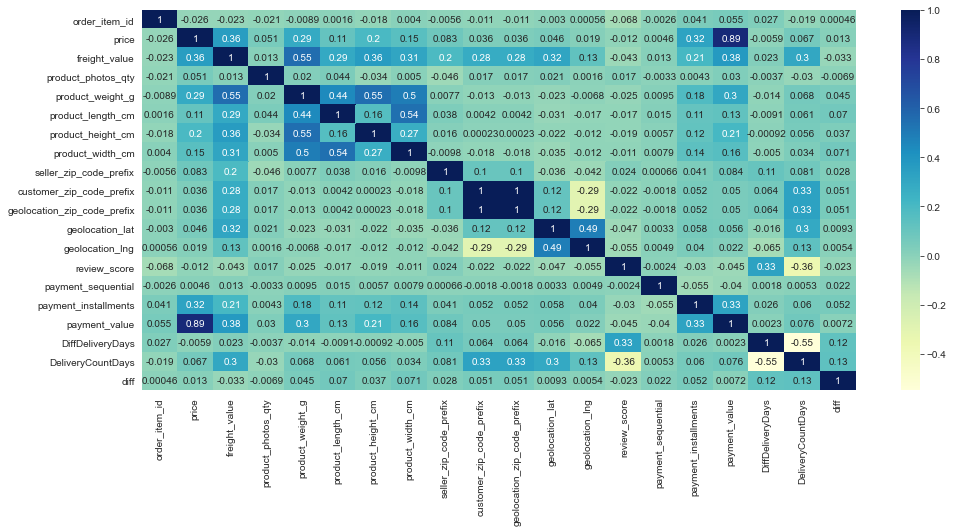

In [54]:
fig, ax = plt.subplots( figsize=(16, 7))
sns.heatmap(df1.corr(method='pearson'), cmap="YlGnBu", annot=True)

## Customer Segmentation - RFM Clustering and k-means

In [55]:
df_analysis = df1.copy()

In [56]:
df_analysis['order_purchase_year'] = df_analysis.order_purchase_timestamp.apply(lambda x: x.year)
df_analysis['order_purchase_month'] = df_analysis.order_purchase_timestamp.apply(lambda x: x.month)
df_analysis['order_purchase_dayofweek'] = df_analysis.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_analysis['order_purchase_hour'] = df_analysis.order_purchase_timestamp.apply(lambda x: x.hour)
df_analysis['order_purchase_day'] = df_analysis['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df_analysis['order_purchase_mon'] = df_analysis.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
# Changing the month attribute for correct ordenation
df_analysis['month_year'] = df_analysis['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df_analysis['month_year'] = df_analysis['order_purchase_year'].astype(str) + '-' + df_analysis['month_year'].astype(str)
#creating year month column
df_analysis['month_y'] = df_analysis['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [57]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = df_analysis.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
df2 = pd.merge(df_analysis, df_min_purchase, on='customer_unique_id')

In [58]:
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
df2['usertype'] = 'New'
df2.loc[df2['month_y']>df2['minpurchasedate'],'usertype'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = df2.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue.head()

month_y  usertype month_year  payment_value
0   201609       New    2016-09         211.29
1   201610       New    2016-10       11996.36
2   201701       New    2017-01       36748.06
3   201702  Existing    2017-02          59.76
4   201702       New    2017-02      161776.69

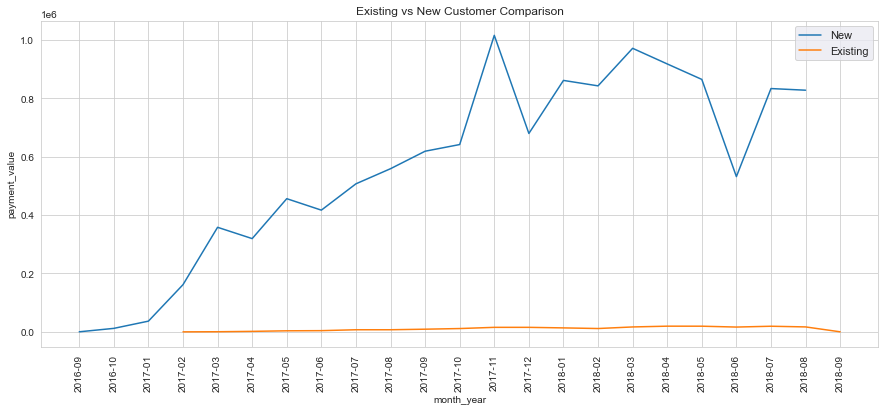

In [59]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [60]:
#identifying active users are active by looking at their revenue per month
df_user_purchase = df_analysis.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

customer_unique_id  month_y  payment_value
0  0000366f3b9a7992bf8c76cfdf3221e2   201805         141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f   201805          27.19
2  0000f46a3911fa3c0805444483337064   201703          86.22
3  0000f6ccb0745a6a4b88665a16c9f078   201710          43.62
4  0004aac84e0df4da2b147fca70cf8255   201711         196.89

In [61]:
#identifying active users are active by looking at their order count per month
df_user_purchase = df_analysis.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

customer_unique_id  month_y  payment_value
0  0000366f3b9a7992bf8c76cfdf3221e2   201805              1
1  0000b849f77a49e4a4ce2b2a4ca5be3f   201805              1
2  0000f46a3911fa3c0805444483337064   201703              1
3  0000f6ccb0745a6a4b88665a16c9f078   201710              1
4  0004aac84e0df4da2b147fca70cf8255   201711              1

In [62]:
#create retention matrix with crosstab using purchase
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

month_y                customer_unique_id  201609  201610  201701  201702  \
0        0000366f3b9a7992bf8c76cfdf3221e2       0       0       0       0   
1        0000b849f77a49e4a4ce2b2a4ca5be3f       0       0       0       0   
2        0000f46a3911fa3c0805444483337064       0       0       0       0   
3        0000f6ccb0745a6a4b88665a16c9f078       0       0       0       0   
4        0004aac84e0df4da2b147fca70cf8255       0       0       0       0   

month_y  201703  201704  201705  201706  201707  ...  201712  201801  201802  \
0             0       0       0       0       0  ...       0       0       0   
1             0       0       0       0       0  ...       0       0       0   
2             1       0       0       0       0  ...       0       0       0   
3             0       0       0       0       0  ...       0       0       0   
4             0       0       0       0       0  ...       0       0       0   

month_y  201803  201804  201805  201806  201807  201808  201809  
0             0       0       1       0       0       0       0  
1             0       0       1       0       0       0       0  
2             0       0       0       0       0       0       0  
3             0       0       0       0       0       0       0  
4             0       0       0       0       0       0       0  

[5 rows x 24 columns]

In [63]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df1['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df1.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

customer_unique_id  Recency
0  7c396fd4830fd04220f754e42b4e5bff      335
1  7c396fd4830fd04220f754e42b4e5bff      335
2  8a4002923e801e3120a11070fd31c9e2      164
3  3a51803cc0d012c3b5dc8b7528cb05f7      383
4  806ab9e6d7c897da7e3b6104dadadc34       38

In [64]:
# getting summary statistics of the recency table
df_user.Recency.describe()

count    84685.000000
mean       240.577233
std        147.894050
min          0.000000
25%        123.000000
50%        224.000000
75%        348.000000
max        728.000000
Name: Recency, dtype: float64

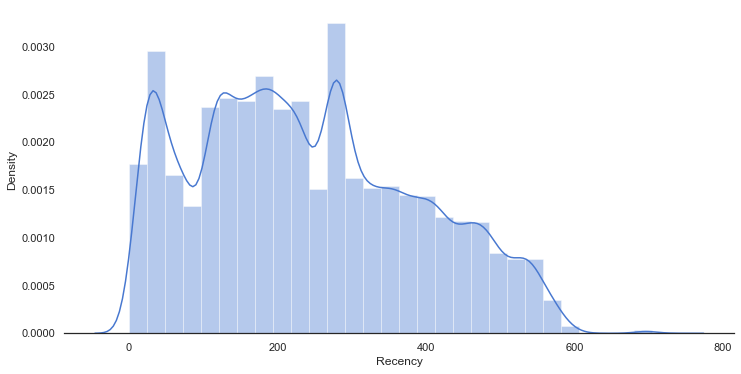

In [65]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

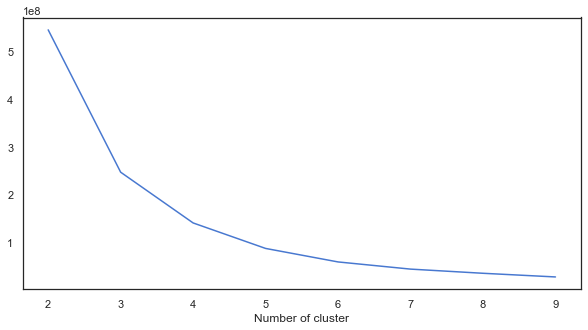

In [66]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 4 is the optimal number of clusters. Based on business requirements, I can go ahead with less or more clusters. In this case i will be selecting 5.

In [67]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [68]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                               
0               10543.0  499.996111  42.356583  439.0  466.0  493.0  532.0   
1               14491.0  375.330274  33.999837  319.0  347.0  374.0  405.0   
2               20681.0  261.481747  31.027603  208.0  233.0  267.0  283.0   
3               23069.0  153.548528  31.000602   99.0  125.0  153.0  181.0   
4               15901.0   44.839821  23.639261    0.0   26.0   41.0   65.0   

                  max  
RecencyCluster         
0               728.0  
1               438.0  
2               318.0  
3               207.0  
4                98.0

From the above table the recency clusters have different characteristics. The customers in Cluster 4 are very recent compared to Cluster 3 and 2. Hence cluster 4 covers the most active customers wheras cluster 0 covers the most inactive

In [69]:
#get order counts for each user and create a dataframe with it
df_frequency = df1.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

In [70]:
# getting summary statistics of the recency table
df_user.Frequency.describe()

count    84685.000000
mean         1.066883
std          0.356011
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: Frequency, dtype: float64

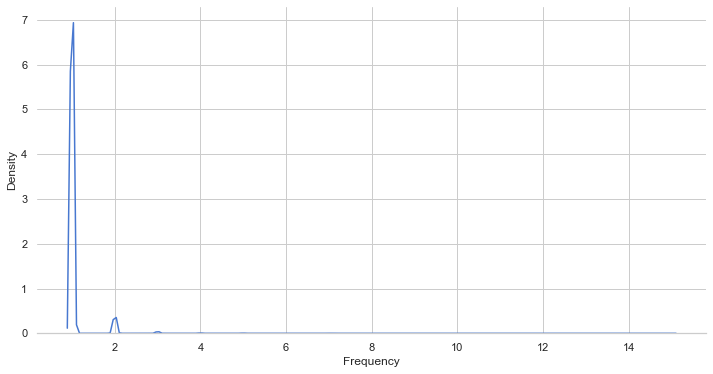

In [71]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

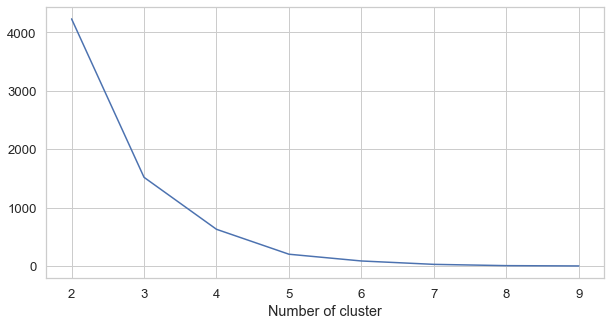

In [191]:
sse={}
df_revenue = df_user[['Frequency']]
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [72]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

count       mean       std   min   25%   50%   75%   max
FrequencyCluster                                                            
0                 80022.0   1.000000  0.000000   1.0   1.0   1.0   1.0   1.0
1                  4118.0   2.000000  0.000000   2.0   2.0   2.0   2.0   2.0
2                   461.0   3.147505  0.354994   3.0   3.0   3.0   3.0   4.0
3                    69.0   6.014493  1.408929   5.0   5.0   5.0   7.0   9.0
4                    15.0  15.000000  0.000000  15.0  15.0  15.0  15.0  15.0

high frequency number indicates better customers

In [73]:
#calculate revenue for each customer
df_revenue = df2.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

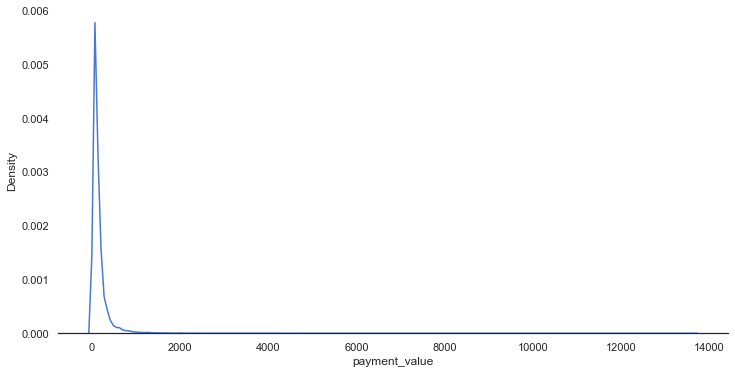

In [74]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

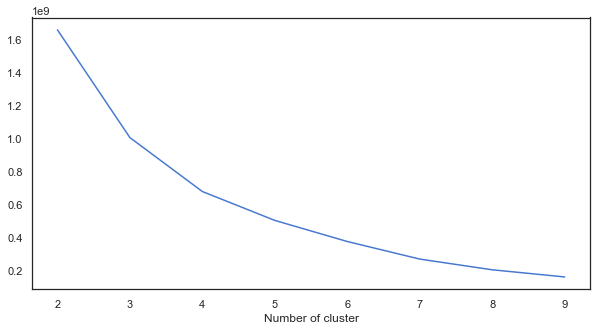

In [75]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [76]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

count         mean          std      min        25%  \
RevenueCluster                                                          
0               51180.0    70.928791    30.508914     0.01    45.7000   
1               25002.0   191.492045    46.562050   131.06   153.0900   
2                6552.0   432.137224   102.160253   311.17   348.0700   
3                1662.0   940.633273   211.597401   685.41   767.2300   
4                 286.0  2067.359755   582.207221  1504.61  1659.0675   
5                   3.0  9006.833333  4077.189593  6081.54  6678.2100   

                     50%         75%       max  
RevenueCluster                                  
0                 68.230     95.7200    131.05  
1                180.320    221.8075    311.14  
2                401.285    500.9775    684.80  
3                875.400   1069.1750   1490.53  
4               1875.050   2217.2350   4764.34  
5               7274.880  10469.4800  13664.08

In [77]:
#renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

Recency  Frequency     Monetary
OverallScore                                    
0             499.958301   1.000000    70.062687
1             406.631739   1.009739   100.097756
2             300.015406   1.020658   113.081065
3             201.434929   1.030757   129.697815
4             115.016100   1.054323   164.858311
5              99.217314   1.162437   292.669765
6              95.985162   1.461331   527.866668
7              80.992754   1.765217   828.786739
8              77.962963   2.661376  1041.338995
9             111.322034   5.000000  1102.358983
10             54.400000   5.800000  1613.557000
11             28.000000  12.500000  1012.802500

In [78]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

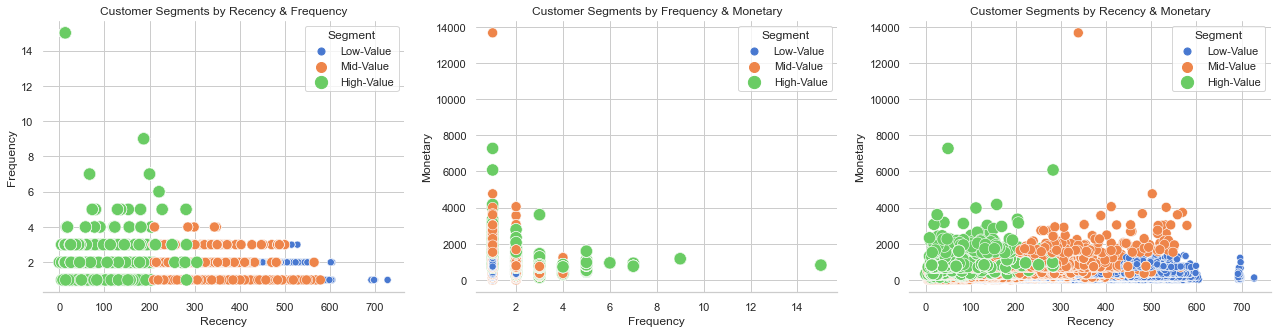

In [79]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

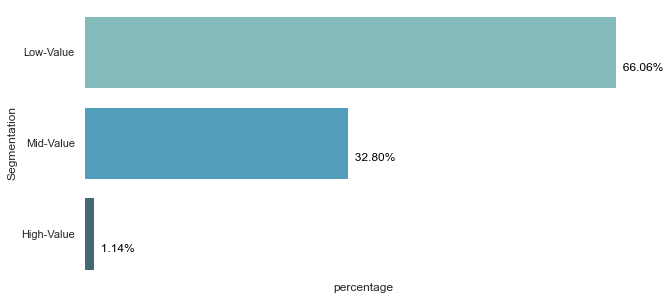

In [80]:
plt.figure(figsize=(10,5))
percentage = (df_user['Segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

In [236]:
df_user[['Frequency','Monetary']].groupby('Frequency').mean()

Monetary
Frequency             
1           149.823622
2           282.417484
3           427.773969
4           532.795882
5           849.040000
6           944.210000
7           842.225000
9          1172.660000
15          820.150000

In [224]:
df_user[['customer_unique_id','Frequency']].groupby('Frequency').count()

customer_unique_id
Frequency                    
1                       80022
2                        4118
3                         393
4                          68
5                          40
6                           6
7                          14
9                           9
15                         15

In [205]:
df_user.head()

customer_unique_id  Recency  RecencyCluster  Frequency  \
0  7c396fd4830fd04220f754e42b4e5bff      335               1          2   
1  7c396fd4830fd04220f754e42b4e5bff      335               1          2   
2  118be57d1b7de439453a0c6625ad7934      379               1          2   
3  118be57d1b7de439453a0c6625ad7934      379               1          2   
4  53c84ac43bbfafb7a6b5d9076ab423c7      375               1          2   

   FrequencyCluster  Monetary  RevenueCluster  OverallScore    Segment  
0                 1     62.23               0             2  Low-Value  
1                 1     62.23               0             2  Low-Value  
2                 1     87.38               0             2  Low-Value  
3                 1     87.38               0             2  Low-Value  
4                 1     58.27               0             2  Low-Value

### One-Hot Encoding and Scaling of the data

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84685 entries, 0 to 97007
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       84685 non-null  object        
 1   customer_id                    84685 non-null  object        
 2   order_status                   84685 non-null  object        
 3   order_purchase_timestamp       84685 non-null  datetime64[ns]
 4   order_approved_at              84685 non-null  datetime64[ns]
 5   order_delivered_customer_date  84685 non-null  datetime64[ns]
 6   order_estimated_delivery_date  84685 non-null  datetime64[ns]
 7   order_item_id                  84685 non-null  float64       
 8   product_id                     84685 non-null  object        
 9   seller_id                      84685 non-null  object        
 10  shipping_limit_date            84685 non-null  object        
 11  price          

In [82]:
df1['order_item_id'] = df1['order_item_id'].astype('object')
df1['seller_zip_code_prefix'] = df1['seller_zip_code_prefix'].astype('object')
df1['customer_zip_code_prefix'] = df1['customer_zip_code_prefix'].astype('object')

#### Removing correlated features

In [83]:
df1 =df1.drop(['payment_value','order_purchase_timestamp','geolocation_state','geolocation_zip_code_prefix','geolocation_city','geolocation_lng','geolocation_lat','order_id', 'customer_id','customer_unique_id','geolocation_lat','geolocation_lng','DeliveryCountDays','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date'], axis=1)
df1.head()

order_status order_item_id                        product_id  \
0    delivered           1.0  87285b34884572647811a353c7ac498a   
1    delivered           1.0  9abb00920aae319ef9eba674b7d2e6ff   
2    delivered           1.0  6cc44821f36f3156c782da72dd634e47   
3    delivered           1.0  87285b34884572647811a353c7ac498a   
4    delivered           1.0  a0b7d5a992ccda646f2d34e418fff5a0   

                          seller_id  shipping_limit_date  price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
1  1771297ac436903d1dd6b0e9279aa505  2017-09-11 11:43:25  35.39   
2  da8622b14eb17ae2831f4ac5b9dab84a  2018-03-28 18:05:36  99.90   
3  3504c0cb71d7fa48d967e0e4c94d59d9  2017-08-21 20:05:16  29.99   
4  95f83f51203c626648c875dd41874c7f  2018-08-02 02:10:26  69.90   

   freight_value  product_category_name  product_photos_qty  product_weight_g  \
0           8.72  utilidades_domesticas                 4.0             500.0   
1           8.72                  bebes                 1.0             350.0   
2          11.79        cama_mesa_banho                 1.0            1050.0   
3           7.78  utilidades_domesticas                 4.0             500.0   
4          32.18       moveis_decoracao                 2.0           12300.0   

   ...  customer_zip_code_prefix  customer_city  customer_state review_score  \
0  ...                      3149      sao paulo              SP            4   
1  ...                      3149      sao paulo              SP            5   
2  ...                      3149      sao paulo              SP            5   
3  ...                      3366      sao paulo              SP            4   
4  ...                      3366      sao paulo              SP            5   

  payment_sequential payment_type payment_installments DiffDeliveryDays diff  \
0                1.0  credit_card                  1.0                8  335   
1                1.0  credit_card                  1.0               10  335   
2                1.0  credit_card                  2.0               10  164   
3                1.0  credit_card                  3.0               10  383   
4                1.0       boleto                  1.0               13   38   

   churn  
0      1  
1      1  
2      0  
3      1  
4      0  

[5 rows x 26 columns]

In [84]:
cat=[]
num=[]
for i in df1.columns:
  if df1[i].dtype=='object':
    cat.append(i)
  else:
    num.append(i)
print('cat = ',cat)
print('num = ',num)

cat =  ['order_status', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'product_category_name', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'payment_type', 'churn']
num =  ['price', 'freight_value', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_score', 'payment_sequential', 'payment_installments', 'DiffDeliveryDays', 'diff']


In [85]:
df1[cat].describe().T

count  unique                               top  \
order_status                84685       7                         delivered   
order_item_id             84685.0     7.0                               1.0   
product_id                  84685   28048  99a4788cb24856965c36a24e339b6058   
seller_id                   84685    2899  6560211a19b47992c3666cc44a7e94c0   
shipping_limit_date         84685   80148               2017-11-23 20:31:15   
product_category_name       84685      73                   cama_mesa_banho   
seller_zip_code_prefix    84685.0  2131.0                           14940.0   
seller_city                 84685     577                         sao paulo   
seller_state                84685      23                                SP   
customer_zip_code_prefix    84685   14287                             22790   
customer_city               84685    3840                         sao paulo   
customer_state              84685      27                                SP   
payment_type                84685       4                       credit_card   
churn                       84685       2                                 1   

                             freq  
order_status                82607  
order_item_id             83516.0  
product_id                    439  
seller_id                    1691  
shipping_limit_date             5  
product_category_name        8256  
seller_zip_code_prefix     5772.0  
seller_city                 21781  
seller_state                61523  
customer_zip_code_prefix      112  
customer_city               14095  
customer_state              37763  
payment_type                63905  
churn                       51520

<AxesSubplot:>

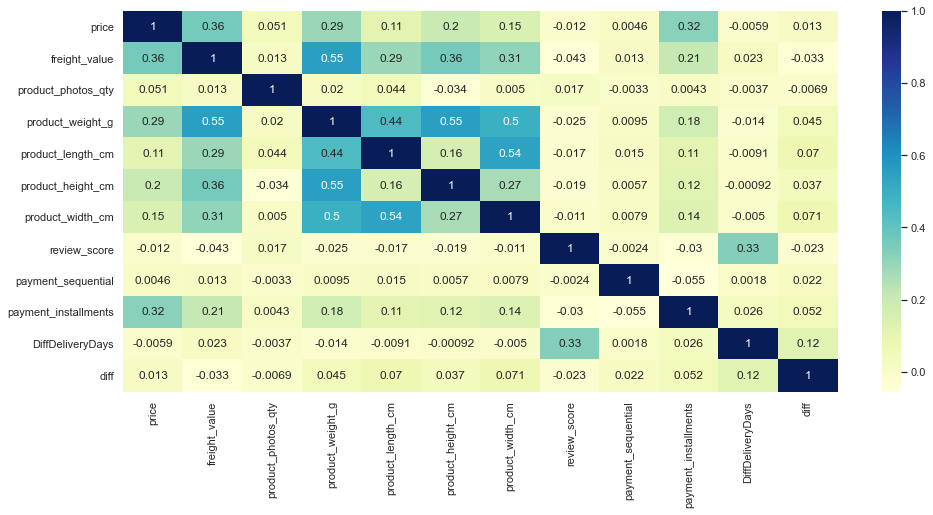

In [86]:
fig, ax = plt.subplots( figsize=(16, 7))
sns.heatmap(df1.corr(method='pearson'), cmap="YlGnBu", annot=True)

Removin diff field as it is used to derive churn

In [87]:
df1 =df1.drop(['diff'], axis=1)
df1.head()

order_status order_item_id                        product_id  \
0    delivered           1.0  87285b34884572647811a353c7ac498a   
1    delivered           1.0  9abb00920aae319ef9eba674b7d2e6ff   
2    delivered           1.0  6cc44821f36f3156c782da72dd634e47   
3    delivered           1.0  87285b34884572647811a353c7ac498a   
4    delivered           1.0  a0b7d5a992ccda646f2d34e418fff5a0   

                          seller_id  shipping_limit_date  price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
1  1771297ac436903d1dd6b0e9279aa505  2017-09-11 11:43:25  35.39   
2  da8622b14eb17ae2831f4ac5b9dab84a  2018-03-28 18:05:36  99.90   
3  3504c0cb71d7fa48d967e0e4c94d59d9  2017-08-21 20:05:16  29.99   
4  95f83f51203c626648c875dd41874c7f  2018-08-02 02:10:26  69.90   

   freight_value  product_category_name  product_photos_qty  product_weight_g  \
0           8.72  utilidades_domesticas                 4.0             500.0   
1           8.72                  bebes                 1.0             350.0   
2          11.79        cama_mesa_banho                 1.0            1050.0   
3           7.78  utilidades_domesticas                 4.0             500.0   
4          32.18       moveis_decoracao                 2.0           12300.0   

   ...  seller_state  customer_zip_code_prefix  customer_city customer_state  \
0  ...            SP                      3149      sao paulo             SP   
1  ...            SP                      3149      sao paulo             SP   
2  ...            SP                      3149      sao paulo             SP   
3  ...            SP                      3366      sao paulo             SP   
4  ...            MG                      3366      sao paulo             SP   

  review_score payment_sequential payment_type payment_installments  \
0            4                1.0  credit_card                  1.0   
1            5                1.0  credit_card                  1.0   
2            5                1.0  credit_card                  2.0   
3            4                1.0  credit_card                  3.0   
4            5                1.0       boleto                  1.0   

  DiffDeliveryDays  churn  
0                8      1  
1               10      1  
2               10      0  
3               10      1  
4               13      0  

[5 rows x 25 columns]

In [93]:
cat=[]
num=[]
for i in df1.columns:
  if df1[i].dtype=='object':
    cat.append(i)
  else:
    num.append(i)
print('cat = ',cat)
print('num = ',num)

cat =  ['order_status', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'product_category_name', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'payment_type', 'churn']
num =  ['price', 'freight_value', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_score', 'payment_sequential', 'payment_installments', 'DiffDeliveryDays']


In [94]:
df_encoded=df1.copy()

In [95]:
df_encoded = df_encoded.apply(LabelEncoder().fit_transform)

In [96]:
df_encoded = pd.get_dummies(df_encoded)

print(df_encoded.shape)

(84685, 25)


In [97]:
scaler = StandardScaler()

In [98]:
features = df_encoded[num]
features = scaler.fit_transform(features)

### Test Train Split

In [99]:
X = df_encoded.drop(['churn'],axis=1)
y = df_encoded['churn']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state=42)

## Model Implementation
### 1. Logistic Regression

In [100]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [101]:
ytrain_predict = model_lr.predict(X_train)
ytest_predict = model_lr.predict(X_test)

In [102]:
ytest_predict_prob=model_lr.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

0         1
0  0.000021  0.999979
1  0.988355  0.011645
2  0.001797  0.998203
3  0.004307  0.995693
4  0.351909  0.648091

In [104]:
# Accuracy - Training Data
Train_LR_Score = model_lr.score(X_train, y_train)
Train_LR_Score

0.9456662927318887

AUC: 0.984


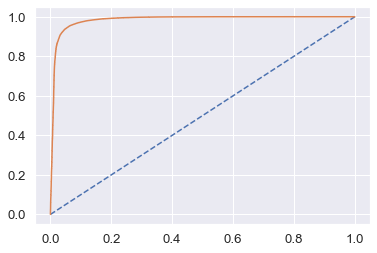

In [152]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
# predict probabilities
probs = model_lr.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
LR_auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % LR_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

In [108]:
# Accuracy - Test Data
Test_LR_Score = model_lr.score(X_test, y_test)
Test_LR_Score

0.9450315876483438

AUC: 0.982


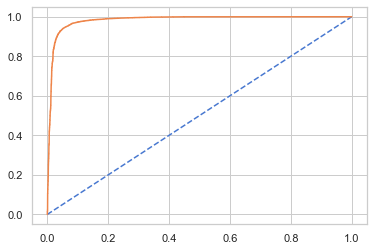

In [109]:
# predict probabilities
probs = model_lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
LR_test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % LR_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

<AxesSubplot:>

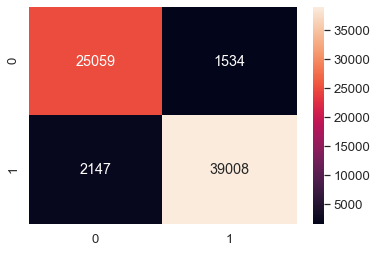

In [110]:
#confusion matrix training Data
cm_lr = confusion_matrix(y_train, ytrain_predict)
cm_lr
sns.set(font_scale = 1.2)
sns.heatmap(cm_lr,annot = True,fmt = 'd')

In [111]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     26593
           1       0.96      0.95      0.95     41155

    accuracy                           0.95     67748
   macro avg       0.94      0.95      0.94     67748
weighted avg       0.95      0.95      0.95     67748



<AxesSubplot:>

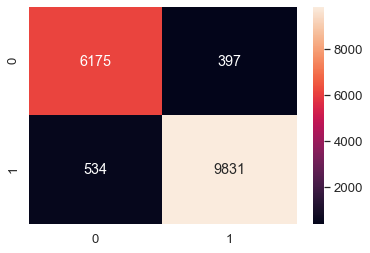

In [112]:
#confusion matrix test Data
cm_test_lr=confusion_matrix(y_test, ytest_predict)
cm_test_lr
sns.set(font_scale = 1.2)
sns.heatmap(cm_test_lr,annot = True,fmt = 'd')

In [113]:
#Test Data Accuracy
test_acc=model_lr.score(X_test,y_test)
test_acc

0.9450315876483438

In [114]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6572
           1       0.96      0.95      0.95     10365

    accuracy                           0.95     16937
   macro avg       0.94      0.94      0.94     16937
weighted avg       0.95      0.95      0.95     16937



In [238]:
predict_LR_score = roc_auc_score(y_test,ytest_predict)
predict_LR_score

0.9440363362350294

## Model 2: Decision Tree

In [240]:
from sklearn import tree
DT_model= tree.DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

DecisionTreeClassifier()

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26593
           1       1.00      1.00      1.00     41155

    accuracy                           1.00     67748
   macro avg       1.00      1.00      1.00     67748
weighted avg       1.00      1.00      1.00     67748



<AxesSubplot:>

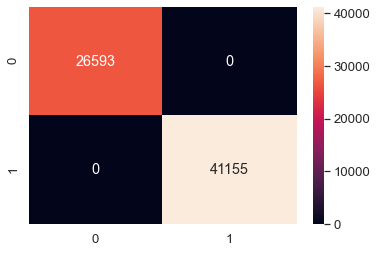

In [241]:
## Performance Matrix on train data set
y_train_predict = DT_model.predict(X_train)
Train_DT_Score = DT_model.score(X_train, y_train)
print(Train_DT_Score)
print(metrics.classification_report(y_train, y_train_predict))
#confusion matrix training Data
cm_train_dt = confusion_matrix(y_train, y_train_predict)
sns.set(font_scale = 1.2)
sns.heatmap(cm_train_dt, annot = True,fmt = 'd')

0.9779772096593258
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6572
           1       0.98      0.98      0.98     10365

    accuracy                           0.98     16937
   macro avg       0.98      0.98      0.98     16937
weighted avg       0.98      0.98      0.98     16937

Confusion Matrix


<AxesSubplot:>

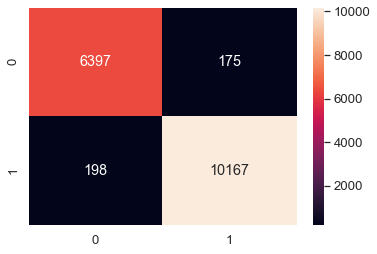

In [242]:
## Performance Matrix on test data set
y_test_predict = DT_model.predict(X_test)
Test_DT_Score = DT_model.score(X_test, y_test)
print(Test_DT_Score)
print(metrics.classification_report(y_test, y_test_predict))
#confusion matrix test Data
cm_test_dt = confusion_matrix(y_test, y_test_predict)
sns.set(font_scale = 1.2)
print('Confusion Matrix')
sns.heatmap(cm_test_dt, annot = True,fmt = 'd')

AUC: 1.000


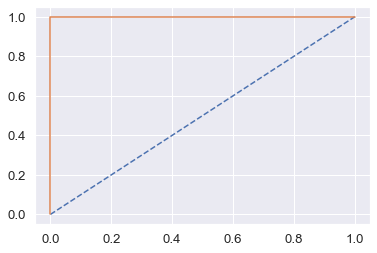

In [243]:
# predict probabilities
probs = DT_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
DT_train_auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % DT_train_auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.977


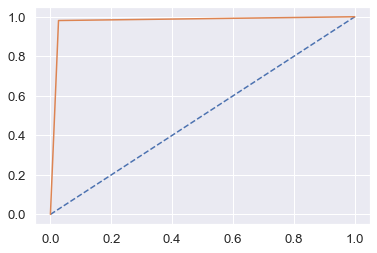

In [244]:
# predict probabilities
probs = DT_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
DT_test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % DT_test_auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

In [278]:
predict_DT_score = roc_auc_score(y_test,probs)
predict_DT_score

0.9879111604758628

## Model 3: Random Forest

In [266]:
RF_model=RandomForestClassifier(n_estimators=100,max_depth=5, random_state=2)
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=2)

0.9894609434964869
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     26593
           1       0.99      1.00      0.99     41155

    accuracy                           0.99     67748
   macro avg       0.99      0.99      0.99     67748
weighted avg       0.99      0.99      0.99     67748

Confusion Matrix


<AxesSubplot:>

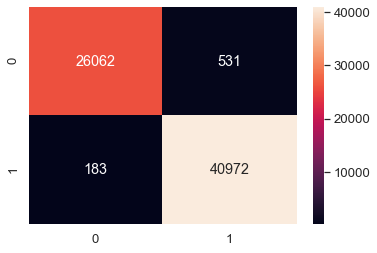

In [267]:
## Performance Matrix on train data set
y_train_predict = RF_model.predict(X_train)
Train_RF_Score =RF_model.score(X_train, y_train)
print(Train_RF_Score)
print(metrics.classification_report(y_train, y_train_predict))
#confusion matrix training Data
cm_train_rf = confusion_matrix(y_train, y_train_predict)
print('Confusion Matrix')
sns.set(font_scale = 1.2)
sns.heatmap(cm_train_rf, annot = True,fmt = 'd')

0.9883686603294563
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6572
           1       0.99      1.00      0.99     10365

    accuracy                           0.99     16937
   macro avg       0.99      0.99      0.99     16937
weighted avg       0.99      0.99      0.99     16937

Confusion Matrix


<AxesSubplot:>

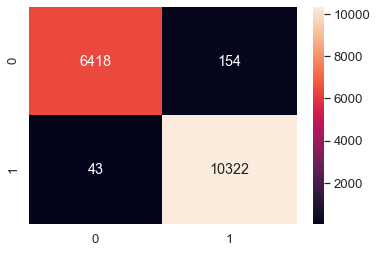

In [268]:
## Performance Matrix on test data set
y_test_predict = RF_model.predict(X_test)
Test_RF_Score = RF_model.score(X_test, y_test)
print(Test_RF_Score)
print(metrics.classification_report(y_test, y_test_predict))
#confusion matrix test Data
cm_test_rf = confusion_matrix(y_test, y_test_predict)
sns.set(font_scale = 1.2)
print('Confusion Matrix')
sns.heatmap(cm_test_rf, annot = True,fmt = 'd')

In [269]:
predict_RF_Score = roc_auc_score(y_test,y_test_predict)
predict_RF_Score

0.986209339039836

AUC: 0.990


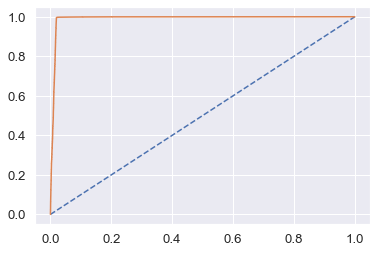

In [270]:
# predict probabilities
probs = RF_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
RF_train_AUC = roc_auc_score(y_train, probs)
print('AUC: %.3f' % RF_train_AUC)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.988


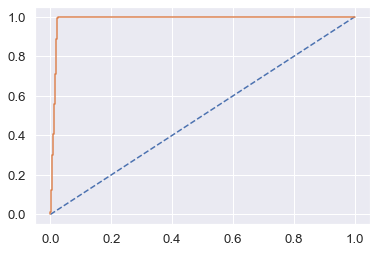

In [271]:
# predict probabilities
probs = RF_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_RF = probs[:, 1]
# calculate AUC
RF_test_AUC = roc_auc_score(y_test, probs_RF)
print('AUC: %.3f' % RF_test_AUC)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs_RF)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

### Model 4: KNN Classifier

In [251]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train,y_train)

KNeighborsClassifier()

0.9887967172462656
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     26593
           1       0.99      1.00      0.99     41155

    accuracy                           0.99     67748
   macro avg       0.99      0.99      0.99     67748
weighted avg       0.99      0.99      0.99     67748

Confusion Matrix


<AxesSubplot:>

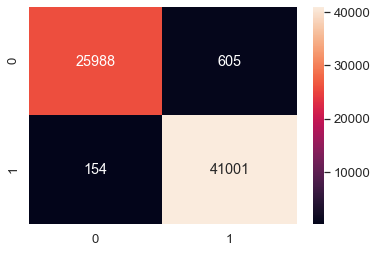

In [252]:
## Performance Matrix on train data set
y_train_predict = KNN_model.predict(X_train)
Train_KNN_Score = KNN_model.score(X_train, y_train)
print(Train_KNN_Score)
print(metrics.classification_report(y_train, y_train_predict))
#confusion matrix training Data
cm_train_knn = confusion_matrix(y_train, y_train_predict)
print('Confusion Matrix')
sns.set(font_scale = 1.2)
sns.heatmap(cm_train_knn, annot = True,fmt = 'd')

0.9855346283285116
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6572
           1       0.98      0.99      0.99     10365

    accuracy                           0.99     16937
   macro avg       0.99      0.98      0.98     16937
weighted avg       0.99      0.99      0.99     16937

Confusion Matrix


<AxesSubplot:>

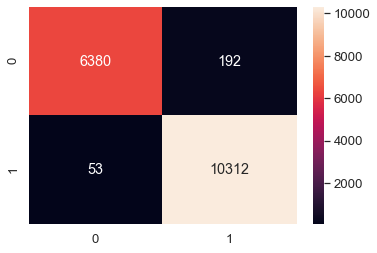

In [253]:
## Performance Matrix on test data set
y_test_predict = KNN_model.predict(X_test)
Test_KNN_Score = KNN_model.score(X_test, y_test)
print(Test_KNN_Score)
print(metrics.classification_report(y_test, y_test_predict))
#confusion matrix test Data
cm_test_knn = confusion_matrix(y_test, y_test_predict)
sns.set(font_scale = 1.2)
print('Confusion Matrix')
sns.heatmap(cm_test_knn, annot = True,fmt = 'd')

AUC: 0.999


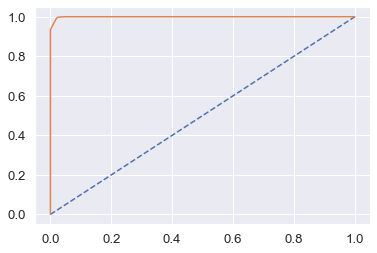

In [254]:
# predict probabilities
probs = KNN_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
KNN_train_AUC = roc_auc_score(y_train, probs)
print('AUC: %.3f' % KNN_train_AUC)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.988


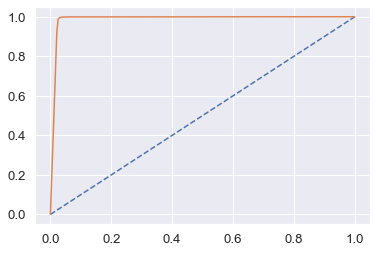

In [255]:
# predict probabilities
probs = KNN_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
KNN_test_AUC = roc_auc_score(y_test, probs)
print('AUC: %.3f' % KNN_test_AUC)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

In [256]:
predict_KNN_score = roc_auc_score(y_test,probs)
predict_KNN_score

0.9879047965920705

### Model 5: XGB Boost

In [257]:
import xgboost as xgb
XGB_model=xgb.XGBClassifier(learning_rate = 0.1, n_estimators=150, min_child_weight=3,  max_depth=13, use_label_encoder=False)
XGB_model.fit(X_train, y_train)

[20:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=13, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

0.9957932337485977
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26593
           1       0.99      1.00      1.00     41155

    accuracy                           1.00     67748
   macro avg       1.00      0.99      1.00     67748
weighted avg       1.00      1.00      1.00     67748

Confusion Matrix


<AxesSubplot:>

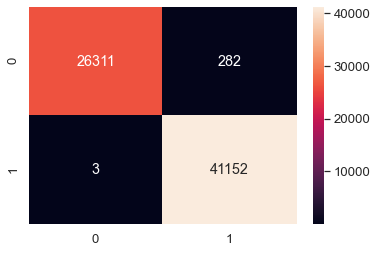

In [258]:
## Performance Matrix on train data set
y_train_predict = XGB_model.predict(X_train)
Train_XGB_Score = XGB_model.score(X_train, y_train)
print(Train_XGB_Score)
print(metrics.classification_report(y_train, y_train_predict))
#confusion matrix training Data
cm_train_knn = confusion_matrix(y_train, y_train_predict)
print('Confusion Matrix')
sns.set(font_scale = 1.2)
sns.heatmap(cm_train_knn, annot = True,fmt = 'd')

0.9897266339965756
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6572
           1       0.99      1.00      0.99     10365

    accuracy                           0.99     16937
   macro avg       0.99      0.99      0.99     16937
weighted avg       0.99      0.99      0.99     16937

Confusion Matrix


<AxesSubplot:>

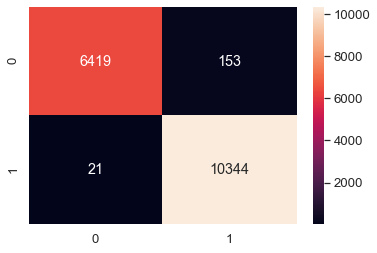

In [259]:
## Performance Matrix on test data set
y_test_predict = XGB_model.predict(X_test)
Test_XGB_Score = XGB_model.score(X_test, y_test)
print(Test_XGB_Score)
print(metrics.classification_report(y_test, y_test_predict))
#confusion matrix test Data
cm_test_knn = confusion_matrix(y_test, y_test_predict)
sns.set(font_scale = 1.2)
print('Confusion Matrix')
sns.heatmap(cm_test_knn, annot = True,fmt = 'd')

AUC: 1.000


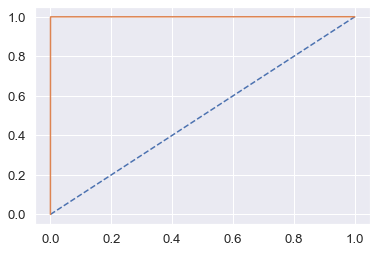

In [260]:
# predict probabilities
probs = XGB_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
XGB_train_AUC = roc_auc_score(y_train, probs)
print('AUC: %.3f' % XGB_train_AUC)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr)

AUC: 0.991


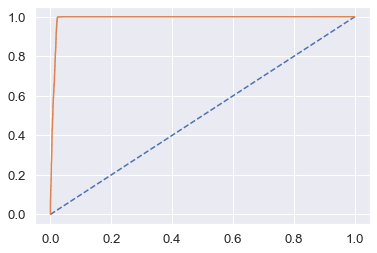

In [262]:
# predict probabilities
probs = XGB_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_XGB = probs[:, 1]
# calculate AUC
XGB_test_AUC = roc_auc_score(y_test, probs_XGB)
print('AUC: %.3f' % XGB_test_AUC)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs_XGB)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr)

In [264]:
predict_score_XGB = roc_auc_score(y_test,probs_XGB)
predict_score_XGB

0.9909746034793928

In [279]:
Models = pd.DataFrame(index= ['Logistic Rgression','Decision Tree','Random Forest','KNN Classifier','XGB Boost'])
Models['Train Model Score'] = [Train_LR_Score,Train_DT_Score, Train_RF_Score, Train_KNN_Score,Train_XGB_Score ]
Models['Test Model Score'] = [Test_LR_Score,Test_DT_Score, Test_RF_Score, Test_KNN_Score,Test_XGB_Score ]
Models['Prediction Score'] = [predict_LR_score,predict_DT_score, predict_RF_Score, predict_KNN_score,predict_score_XGB ]
Models['Test AUC Score'] = [LR_auc,DT_test_auc,RF_test_AUC, KNN_test_AUC,XGB_test_AUC ]
Models

Train Model Score  Test Model Score  Prediction Score  \
Logistic Rgression           0.945666          0.945032          0.944036   
Decision Tree                1.000000          0.977977          0.987911   
Random Forest                0.989461          0.988369          0.986209   
KNN Classifier               0.988797          0.985535          0.987905   
XGB Boost                    0.995793          0.989727          0.990975   

                    Test AUC Score  
Logistic Rgression        0.983528  
Decision Tree             0.977135  
Random Forest             0.987911  
KNN Classifier            0.987905  
XGB Boost                 0.990975